# LSTM with stock market data and sentiment

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import sys
import numpy as np
import seaborn as sns
from IPython.display import clear_output
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import src.preprocess_data as preprocess_data
import models.LSenTiMent as LSenTiMent

importlib.reload(preprocess_data)
importlib.reload(LSenTiMent)

# Set seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Set PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [149]:
# STOCKS_DATA_PATH = "../data/processed/stocks.csv"
STOCKS_DATA_PATH = "../data/apple_stock/AAPL_1980-12-03_2025-03-15.csv"
# SENTIMENT_DATA_PATH = "../data/processed/sentiment140.csv"
SENTIMENT_DATA_PATH = "../data/sentiment-emotion/sentiment-emotion-labelled_Dell_tweets.csv"

FOCUS_PRICE = "Close"
FOCUS_STOCK = "AAPL"

WINDOW_SIZE = 3
BATCH_SIZE = 16
LEARNING_RATE = 1e-2
EPOCHS = 2000

SCHEDULER = True
SCHEDULER_GAMMA = 0.8
SCHEDULER_STEP_SIZE = 100

LSTM_HIDDEN_SIZE = 2
LSTM_NUM_LAYERS = 1

## Data Preparation

### Processing

In [150]:
df_stocks = pd.read_csv(STOCKS_DATA_PATH)

df_stocks.columns = ["Date", "Open", "High", "Low", "Close", "AdjClose", "Volume"]


# TODO: Expand this or use tweets from a larger period of time
# df_stocks = df_stocks[df_stocks["Name"] == FOCUS_STOCK]
# df_stocks = df_stocks[:1000]

df_stocks = df_stocks[["Date", FOCUS_PRICE]]

# df_stocks[FOCUS_PRICE] = (df_stocks[FOCUS_PRICE] - df_stocks[FOCUS_PRICE].min()) / (df_stocks[FOCUS_PRICE].max() - df_stocks[FOCUS_PRICE].min())
# df_stocks[FOCUS_PRICE] = (df_stocks[FOCUS_PRICE] - df_stocks[FOCUS_PRICE].mean()) / df_stocks[FOCUS_PRICE].std()

df_stocks["Date"] = df_stocks["Date"].apply(lambda x: x.split(" ")[0])
df_stocks["Date"] = df_stocks["Date"].apply(preprocess_data.convert_date)

df_stocks.set_index("Date", inplace=True)

df_stocks = preprocess_data.apply_time_window(df = df_stocks,
                                              price_col_name=FOCUS_PRICE,
                                              n = WINDOW_SIZE)

print(len(df_stocks))
display(df_stocks.head(10))

11151


,Close,Close-3,Close-2,Close-1
Date,,,,
1980-12-17,0.115513,0.128348,0.121652,0.112723
1980-12-18,0.118862,0.121652,0.112723,0.115513
1980-12-19,0.126116,0.112723,0.115513,0.118862
1980-12-22,0.132254,0.115513,0.118862,0.126116
1980-12-23,0.137835,0.118862,0.126116,0.132254
1980-12-24,0.145089,0.126116,0.132254,0.137835
1980-12-26,0.158482,0.132254,0.137835,0.145089
1980-12-29,0.160714,0.137835,0.145089,0.158482
1980-12-30,0.156808,0.145089,0.158482,0.160714


In [151]:
daily_sentiment = pd.read_csv("../data/financial_tweets/financial_tweets_sentiments.csv")
daily_sentiment.columns = ["Date", "description", "average_sentiment"]

apple_keywords = ["apple", "iphone", "imac", "macbook", "airpods", "icloud", "appstore", "app store", "appl"]
apple_keywords = "|".join(apple_keywords)

# mask = daily_sentiment["description"].str.lower().str.contains(rf"\b({apple_keywords})\b", na=False)
# daily_sentiment.loc[mask, "average_sentiment"] *= 10

daily_sentiment = preprocess_data.apply_time_window(df = daily_sentiment,
                                                    price_col_name = "average_sentiment",
                                                    n = WINDOW_SIZE)

daily_sentiment["Date"] = pd.to_datetime(daily_sentiment["Date"])

daily_sentiment.set_index("Date", inplace=True)

daily_sentiment.head()

,description,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
Date,,,,,
2022-01-04,$CRV $SRM\n\nLooking for this new 1D UCTS Buy ...,0.019129,-0.035238,0.056101,0.071395
2022-01-05,$FTM cares zero about your sell off $LINK PAIR...,-0.028683,0.056101,0.071395,0.019129
2022-01-06,RT @ShardiB2: $REFI\n\nBounced off support... ...,-0.046476,0.071395,0.019129,-0.028683
2022-05-19,$ALGO - Lower time frame long. Liking the supe...,0.009375,0.019129,-0.028683,-0.046476
2022-05-20,Next week i have a bunch of exciting and alpha...,-0.072355,-0.028683,-0.046476,0.009375


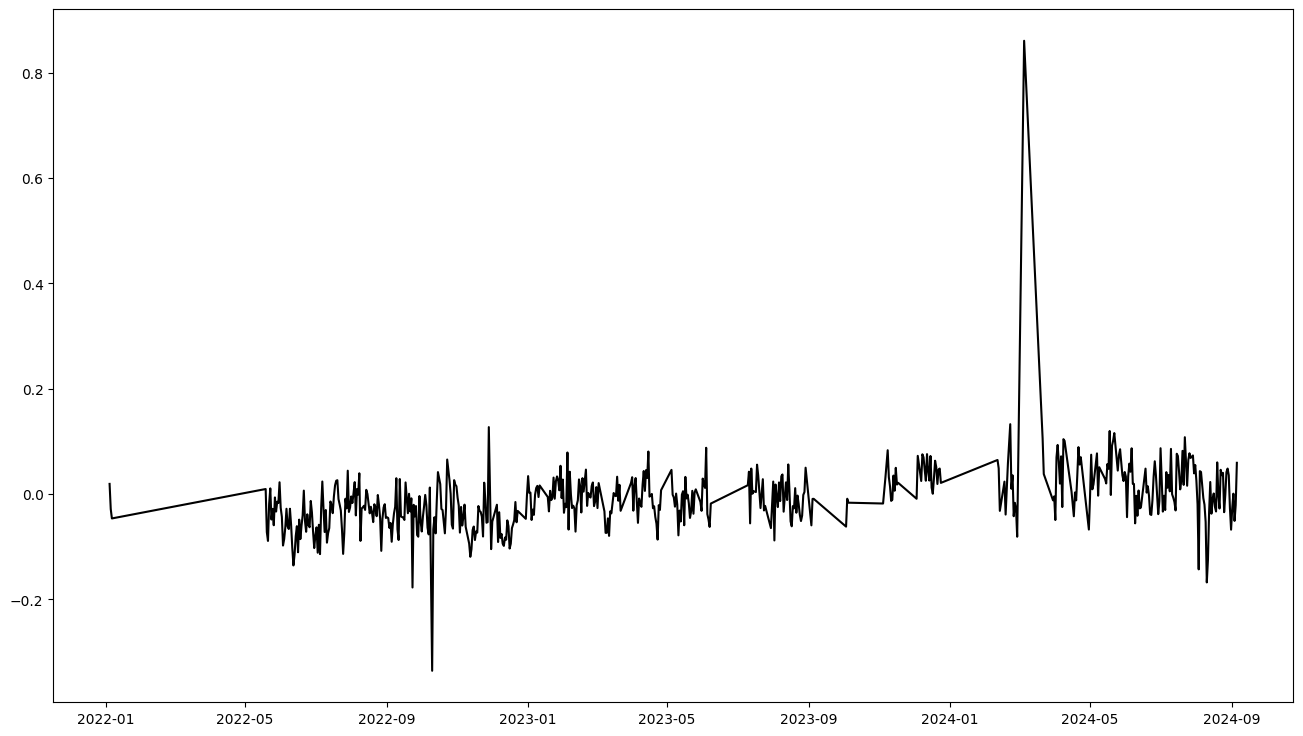

In [152]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(daily_sentiment["average_sentiment"], color="black")

In [155]:
df = pd.merge(df_stocks, daily_sentiment, how="left", left_index=True, right_index=True)
# df["average_sentiment"] = df["average_sentiment"].shift(1)
display(df.head())
print(len(df))

,Close,Close-3,Close-2,Close-1,description,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
Date,,,,,,,,,
1980-12-17,0.115513,0.128348,0.121652,0.112723,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.118862,0.121652,0.112723,0.115513,NaN,NaN,NaN,NaN,NaN
1980-12-19,0.126116,0.112723,0.115513,0.118862,NaN,NaN,NaN,NaN,NaN
1980-12-22,0.132254,0.115513,0.118862,0.126116,NaN,NaN,NaN,NaN,NaN
1980-12-23,0.137835,0.118862,0.126116,0.132254,NaN,NaN,NaN,NaN,NaN


11151


In [156]:
# df["average_sentiment"] = df["average_sentiment"].fillna(0.5)
df = df[df["average_sentiment"].notna()]
for i in range(1, WINDOW_SIZE + 1):
    df = df[df[f"average_sentiment-{i}"].notna()]
print(len(df))

408


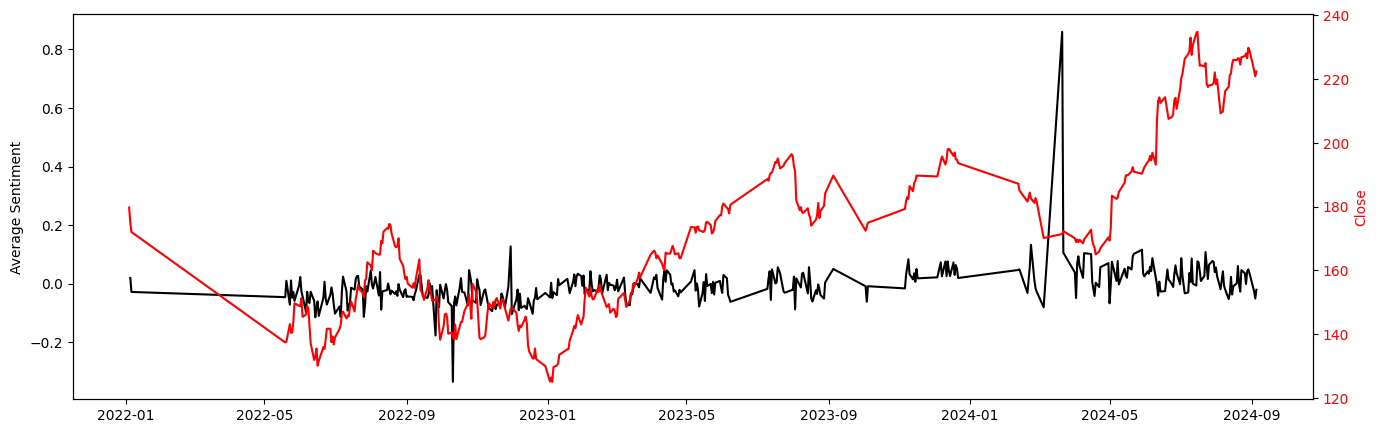

In [157]:
fig, ax1 = plt.subplots(figsize=(16, 5))

df_ = df.copy()
df_["average_sentiment"] = df_["average_sentiment"].shift(1)

ax1.plot(df_["average_sentiment"], color="black", label="Average sentiment")
ax1.set_ylabel("Average Sentiment", color="black")
ax1.tick_params(axis='y', labelcolor="black")

ax2 = ax1.twinx()

ax2.plot(df_[FOCUS_PRICE], color="red", label=FOCUS_PRICE)
ax2.set_ylabel(FOCUS_PRICE, color="red")
ax2.tick_params(axis='y', labelcolor="red")

plt.show()

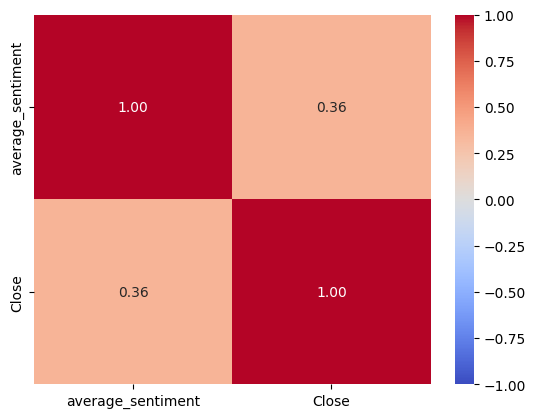

In [158]:
corr = df[["average_sentiment", FOCUS_PRICE]].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.show()

In [159]:
df.head()

,Close,Close-3,Close-2,Close-1,description,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
Date,,,,,,,,,
2022-01-04,179.699997,178.199997,177.570007,182.009995,$CRV $SRM\n\nLooking for this new 1D UCTS Buy ...,0.019129,-0.035238,0.056101,0.071395
2022-01-05,174.919998,177.570007,182.009995,179.699997,$FTM cares zero about your sell off $LINK PAIR...,-0.028683,0.056101,0.071395,0.019129
2022-01-06,172.000000,182.009995,179.699997,174.919998,RT @ShardiB2: $REFI\n\nBounced off support... ...,-0.046476,0.071395,0.019129,-0.028683
2022-05-19,137.350006,145.539993,149.240005,140.820007,$ALGO - Lower time frame long. Liking the supe...,0.009375,0.019129,-0.028683,-0.046476
2022-05-20,137.589996,149.240005,140.820007,137.350006,Next week i have a bunch of exciting and alpha...,-0.072355,-0.028683,-0.046476,0.009375


### Conversion to PyTorch, data splitting

In [160]:
if "average_sentiment" in df.columns:
    df = df.drop(columns=["average_sentiment"])
if "description" in df.columns:
    df = df.drop(columns=["description"])

Xy = df.to_numpy()
X = Xy[:, 1:]
# X = np.expand_dims(X, axis=-1)
X = np.stack((X[:, :WINDOW_SIZE], X[:, WINDOW_SIZE:]), axis=2)

y = Xy[:, :1]

print(X.shape, y.shape)

(408, 3, 2) (408, 1)


In [161]:
split = int(len(X) * 0.7)
split2 = int(len(X) * 0.9)

X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:split2], y[split:split2]
X_test, y_test = X[split2:], y[split2:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([285, 3, 2]) torch.Size([285, 1])
torch.Size([82, 3, 2]) torch.Size([82, 1])
torch.Size([41, 3, 2]) torch.Size([41, 1])


In [162]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])

mean = X_train_reshaped.mean(dim=0)
std = X_train_reshaped.std(dim=0)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

### Dataset and DataLoaders

In [163]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [164]:
train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # TODO: Shuffle?
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Modelling

### Training

In [165]:
def train_model(sentiment=False):
    np.random.seed(0)
    torch.manual_seed(0)

    input_size = 1

    model = LSenTiMent.LSenTiMent(input_size=input_size,
             hidden_size=LSTM_HIDDEN_SIZE,
             num_layers=LSTM_NUM_LAYERS,
             window_size=WINDOW_SIZE,
             sentiment=sentiment).to(device)

    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=LEARNING_RATE)

    if SCHEDULER:
        scheduler = StepLR(optimizer,
                           step_size=SCHEDULER_STEP_SIZE,
                           gamma=SCHEDULER_GAMMA)

    best_val_loss = float('inf')
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train(True)

        train_loss = 0
        cnt = 0
        for i, batch in enumerate(train_dataloader):
            X, y = batch[0].to(device), batch[1].to(device)

            if not sentiment:
                X = X[:, :, 0:1]

            out = model(X)
            l = loss(out, y)
            train_loss += l.item()

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            cnt += 1

        train_loss /= cnt

        train_losses.append(train_loss)

        model.train(False)

        val_loss = 0
        cnt = 0
        for i, batch in enumerate(val_dataloader):
            X, y = batch[0].to(device), batch[1].to(device)

            if not sentiment:
                X = X[:, :, 0:1]

            with torch.no_grad():
                out = model(X)
                l = loss(out, y)

                val_loss += l.item()

            cnt += 1

        val_loss /= cnt

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        val_losses.append(val_loss)

        if SCHEDULER:
            scheduler.step()

        if epoch % 100 == 0:
            clear_output(wait=True)
            print(f"[ Epoch {epoch} / {EPOCHS} ] Train loss = {train_loss} Val loss = {val_loss} Best val loss = {best_val_loss}")
            plt.plot(train_losses, color="black", label="Train loss")
            plt.plot(val_losses, color="red", label="Validation loss")
            plt.yscale("log")
            plt.legend()
            plt.show()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best val loss: {best_val_loss}")

    return model

[ Epoch 4900 / 5000 ] Train loss = 37.45930661874659 Val loss = 812.3219970703125 Best val loss = 812.3020172119141


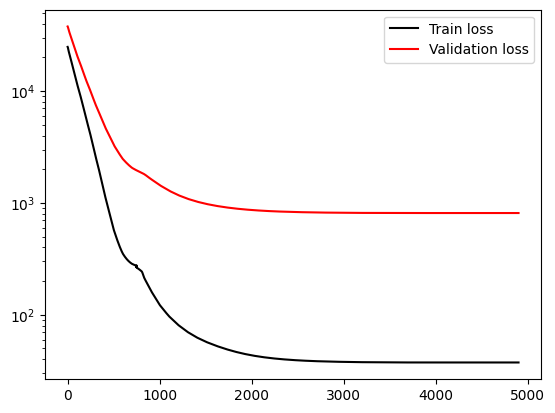

Best val loss: 812.3020172119141


In [142]:
model_no_sentiment = train_model(sentiment=False)

[ Epoch 100 / 2000 ] Train loss = 46.89247759183248 Val loss = 94.97228908538818 Best val loss = 94.97228908538818


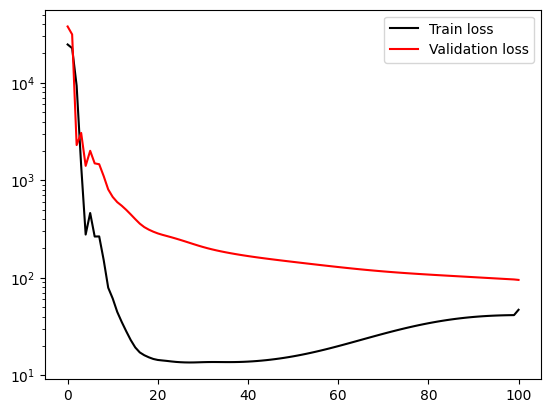

KeyboardInterrupt: 

In [166]:
model_sentiment = train_model(sentiment=True)

## Evaluation

In [144]:
def eval_model(model, sentiment):
    with torch.no_grad():
        if not sentiment:
            X_train_ = X_train[:, :, 0:1]
            X_val_ = X_val[:, :, 0:1]
            X_test_ = X_test[:, :, 0:1]
        else:
            X_train_ = X_train
            X_val_ = X_val
            X_test_ = X_test

        y_train_pred = model(X_train_.to(device)).to("cpu")
        y_train_pred = np.array(y_train_pred)

        y_val_pred = model(X_val_.to(device)).to("cpu")
        y_val_pred = np.array(y_val_pred)

        y_test_pred = model(X_test_.to(device)).to("cpu")
        y_test_pred = np.array(y_test_pred)

    return y_train_pred, y_val_pred, y_test_pred

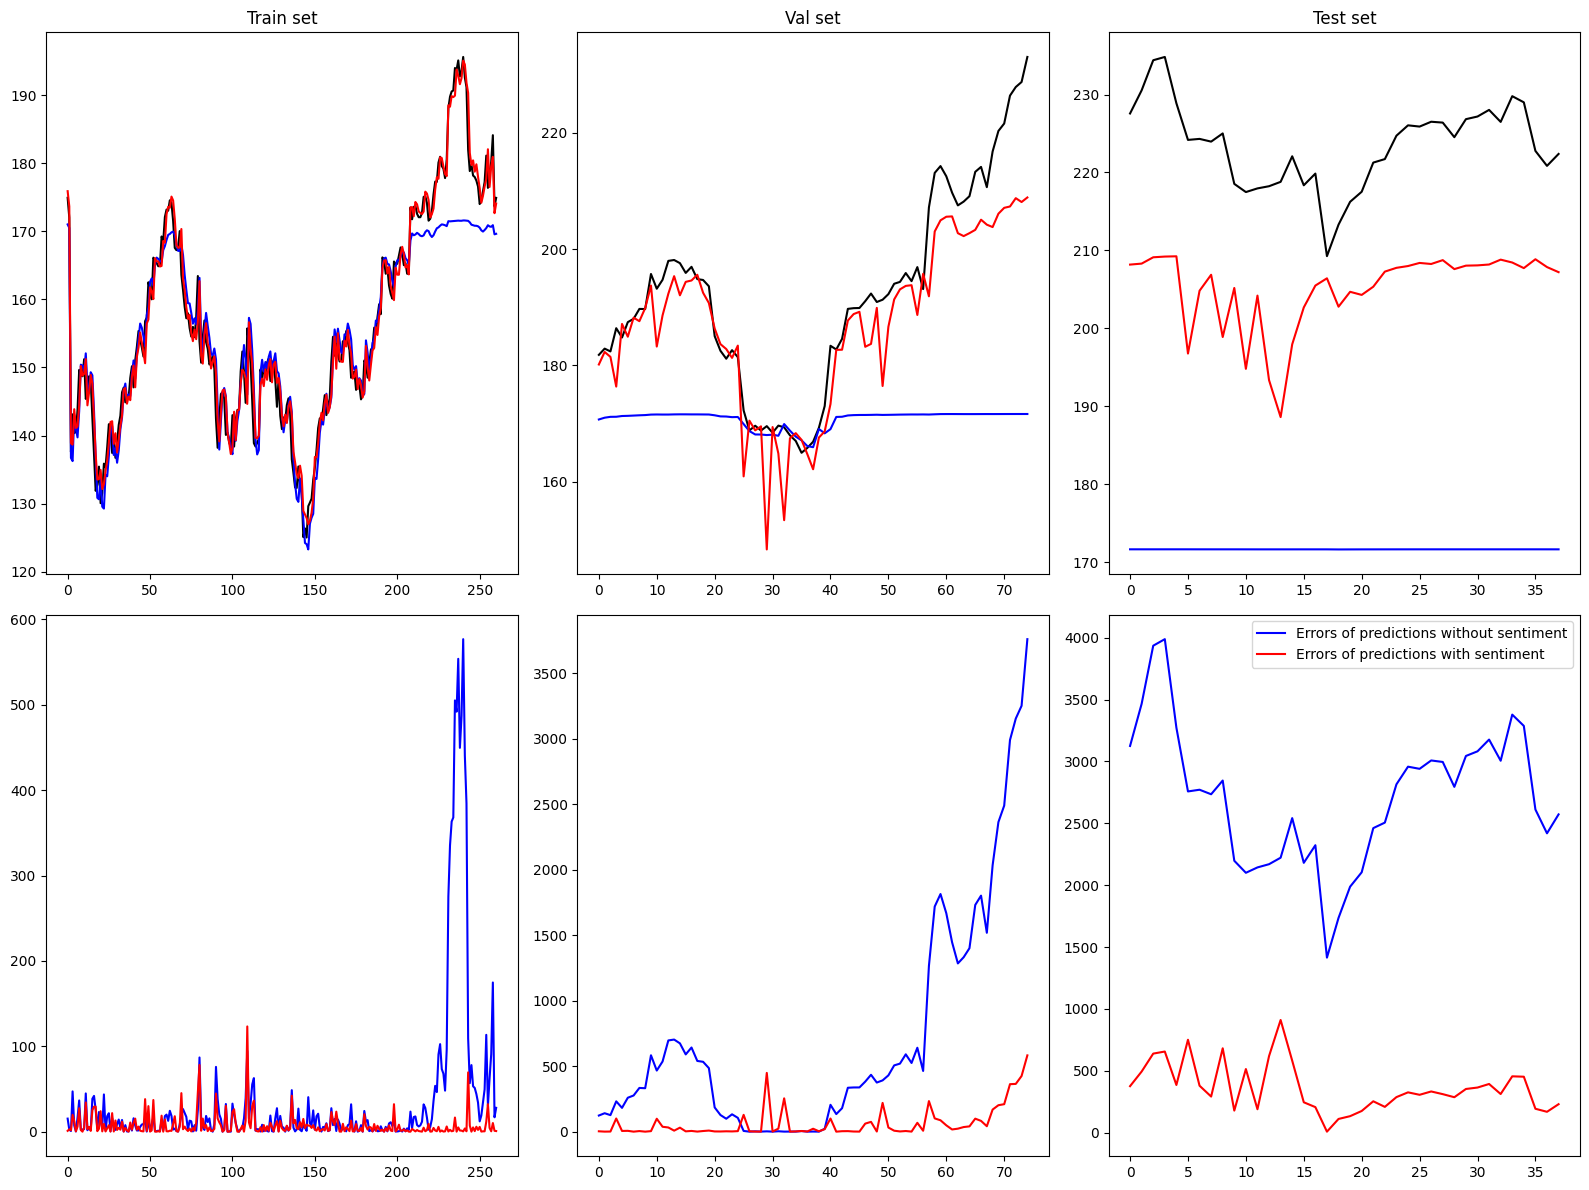

In [145]:
y_train_pred_no_sentiment,y_val_pred_no_sentiment, y_test_pred_no_sentiment = eval_model(model_no_sentiment, sentiment=False)
y_train_pred_sentiment, y_val_pred_sentiment, y_test_pred_sentiment = eval_model(model_sentiment, sentiment=True)

fig, ax = plt.subplots(2, 3, figsize=(16, 12))

ax[0, 0].plot(y_train, color="black", label = "True")
ax[0, 0].plot(y_train_pred_no_sentiment, color="blue", label = "Predictions without sentiment")
ax[0, 0].plot(y_train_pred_sentiment, color="red", label = "Predictions with sentiment")
ax[0, 0].set_title("Train set")

ax[0, 1].plot(y_val, color="black", label = "True")
ax[0, 1].plot(y_val_pred_no_sentiment, color="blue", label = "Predictions without sentiment")
ax[0, 1].plot(y_val_pred_sentiment, color="red", label = "Predictions with sentiment")
ax[0, 1].set_title("Val set")

ax[0, 2].plot(y_test, color="black", label = "True")
ax[0, 2].plot(y_test_pred_no_sentiment, color="blue", label = "Predictions without sentiment")
ax[0, 2].plot(y_test_pred_sentiment, color="red", label = "Predictions with sentiment")
ax[0, 2].set_title("Test set")

ax[1, 0].plot((y_train_pred_no_sentiment - y_train.numpy()) ** 2, color="blue", label = "Errors of predictions without sentiment")
ax[1, 0].plot((y_train_pred_sentiment - y_train.numpy()) ** 2, color="red", label = "Errors of predictions with sentiment")

ax[1, 1].plot((y_val_pred_no_sentiment - y_val.numpy()) ** 2, color="blue", label = "Errors of predictions without sentiment")
ax[1, 1].plot((y_val_pred_sentiment - y_val.numpy()) ** 2, color="red", label = "Errors of predictions with sentiment")

ax[1, 2].plot((y_test_pred_no_sentiment - y_test.numpy()) ** 2, color="blue", label = "Errors of predictions without sentiment")
ax[1, 2].plot((y_test_pred_sentiment - y_test.numpy()) ** 2, color="red", label = "Errors of predictions with sentiment")

plt.legend()
plt.tight_layout()

# TODO: Comparison sentiment vs no sentiment
# TODO: Another lstm for sentiment?
# TODO: Same lstm for sentiment?

# TODO: More weight to sentiments of tweets that contain Apple keywords
# TODO: Take sentiments from the previous few days, not the current day
# TODO: Convolutional NN for feature extraction